In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#imports
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates

In [ ]:
#Load a saved model
model = tf.keras.models.load_model("SP500_Model.h5")

In [ ]:
#load data

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'AAPL model'
symbol = 'AAPL'

import yfinance as yf
df = yf.download(symbol)#, start=start_date, end=end_date)

df.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-24,147.190002,150.229996,146.000000,149.449997,149.202484,75981900
2022-10-25,150.089996,152.490005,149.360001,152.339996,152.087708,74732300
2022-10-26,150.960007,151.990005,148.039993,149.350006,149.102661,88194300
2022-10-27,148.070007,149.050003,144.130005,144.800003,144.560196,109180200
2022-10-28,148.199997,157.500000,147.820007,155.740005,155.482086,164762400
2022-10-31,153.160004,154.240005,151.919998,153.339996,153.086044,97943200
2022-11-01,155.080002,155.449997,149.130005,150.649994,150.400497,80379300
2022-11-02,148.949997,152.169998,145.000000,145.029999,144.789810,93604600
2022-11-03,142.059998,142.800003,138.750000,138.880005,138.650009,97918500


In [ ]:
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 100

# Prediction Index
index_close = data.columns.get_loc("Close")

# Split the training data into train, validation, and test data sets
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
valid_data_len = math.ceil(np_data_scaled.shape[0] * 0.1)

# Create the training, validation, and test data
train_data = np_data_scaled[0:train_data_len, :]
valid_data = np_data_scaled[train_data_len:train_data_len+valid_data_len, :]
test_data = np_data_scaled[(train_data_len+valid_data_len) - sequence_length:, :]

In [ ]:
#function to change data into format where x is the steps used to make the prediction and y is the prediction we want
def partition_dataset(nsteps, data, forcast_range):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(nsteps, data_len-forcast_range):
        x.append(data[i-nsteps:i,:]) #contains sequence_length values 0-sequence_length * column
        y.append(data[i:i+forcast_range, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
#use previous function to get data into right format
x_train, y_train = partition_dataset(sequence_length, train_data, 5)
x_valid, y_valid = partition_dataset(sequence_length, valid_data, 5)
x_test, y_test = partition_dataset(sequence_length, test_data, 5)

In [ ]:
#Create The model

model = Sequential()

inputSize = x_train.shape[1] * x_train.shape[2]

model.add(LSTM(inputSize, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(inputSize, return_sequences=False))
model.add(Dense(5))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
#Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(x_train,y_train,
                    batch_size=16,
                    epochs = 100,
                    validation_data=(x_valid, y_valid),
                    callbacks=early_stop
                    )

Epoch 1/100
156/156 [==============================] - 17s 35ms/step - loss: 4.2959e-04 - val_loss: 9.9775e-04
Epoch 2/100
156/156 [==============================] - 5s 30ms/step - loss: 9.9600e-05 - val_loss: 0.0012
Epoch 3/100
156/156 [==============================] - 5s 30ms/step - loss: 9.0917e-05 - val_loss: 7.4535e-04
Epoch 4/100
156/156 [==============================] - 5s 31ms/step - loss: 9.2292e-05 - val_loss: 0.0018
Epoch 5/100
156/156 [==============================] - 5s 31ms/step - loss: 7.0161e-05 - val_loss: 7.9484e-04
Epoch 6/100
156/156 [==============================] - 5s 31ms/step - loss: 6.2014e-05 - val_loss: 0.0010
Epoch 7/100
156/156 [==============================] - 5s 31ms/step - loss: 6.2111e-05 - val_loss: 8.5972e-04
Epoch 8/100
156/156 [==============================] - 5s 31ms/step - loss: 5.7598e-05 - val_loss: 7.0940e-04
Epoch 9/100
156/156 [==============================] - 5s 31ms/step - loss: 5.3754e-05 - val_loss: 5.5293e-04
Epoch 10/100
156/156 

10/10 [==============================] - 0s 21ms/step


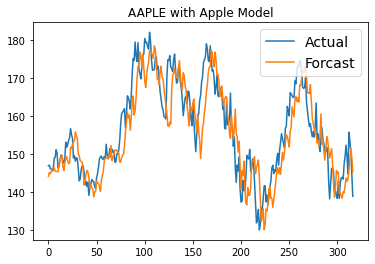

In [ ]:
#Evaluate Performance

#Get predictions
y_pred_scaled = model.predict(x_test)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y = scaler_pred.inverse_transform(y_test.reshape(-1,1))

#create graph
X_new = scaler.inverse_transform(x_test[x_test.shape[0] - 1])[0:,index_close]
Y_new = scaler_pred.inverse_transform(y_test)[y_test.shape[0]-1]
YY = scaler_pred.inverse_transform(y_test)
plt.title("AAPLE with Apple Model")
#plt.plot(X_new)
plt.plot(Y_new, label="Actual", marker = "D")
plt.plot(y_pred[y_pred.shape[0]-1], label="Forcast", marker = "D")
plt.legend(fontsize=14)
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

print(pred_price_unscaled)

1/1 [==============================] - 0s 27ms/step
[[138.47029]
 [139.33092]
 [139.10307]
 [139.8218 ]
 [139.33133]]


In [ ]:
model.save("AAPL_Model.h5")

In [ ]:
from google.colab import files
files.download("AAPL_Model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>